In [32]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [33]:
#BATCH_SIZE = 8
BATCH_SIZE = 32 
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=3 #50

In [35]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Balanced 1500 dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1522 files belonging to 3 classes.


In [36]:
len(dataset)

48

In [37]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Healthy', 'Potato___Late_blight']

In [38]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 1 0 2 1 2 2 1 2 0 2 1 2 1 2 1 1 0 2 2 1 2 2 2 2 1 0 0 2 0 2 1]


# Practice

# Visualize some of the images from our dataset

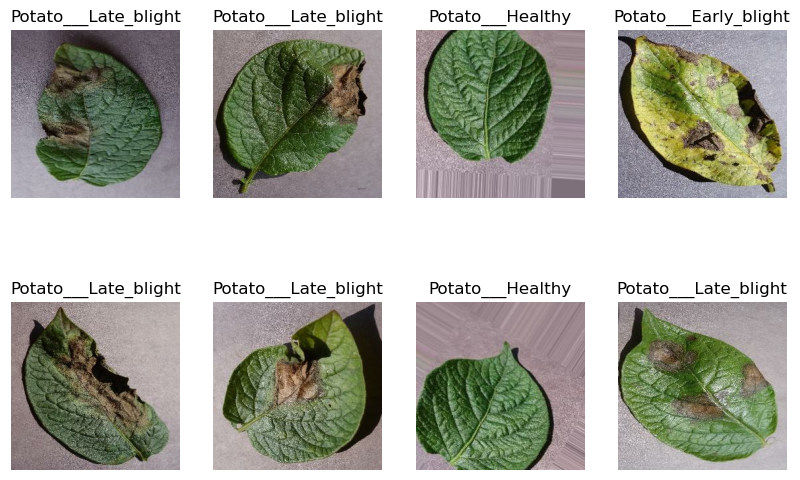

In [39]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Divide the Dataset 

In [40]:
image_count=len(dataset)

In [41]:
train_size = int(image_count*0.8)
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)

In [42]:
print(len(train_ds))
print(len(test_ds))

38
10


# Resizing and Normalization

In [43]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Augmenttion

In [44]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
])

In [45]:
# Data augmentation Only on Train data
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Building 


In [46]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'), #sigmoid
])

model.build(input_shape=input_shape)

In [47]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

# Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [48]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [49]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=test_ds,
    verbose=1,
    epochs=3,
)

Epoch 1/3
38/38 [==============================] - 116s 3s/step - loss: 0.9285 - accuracy: 0.5535 - val_loss: 0.7550 - val_accuracy: 0.6209
Epoch 2/3
38/38 [==============================] - 96s 3s/step - loss: 0.7659 - accuracy: 0.6332 - val_loss: 0.5794 - val_accuracy: 0.7484
Epoch 3/3
38/38 [==============================] - 97s 3s/step - loss: 0.5899 - accuracy: 0.7220 - val_loss: 0.7070 - val_accuracy: 0.6732


In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

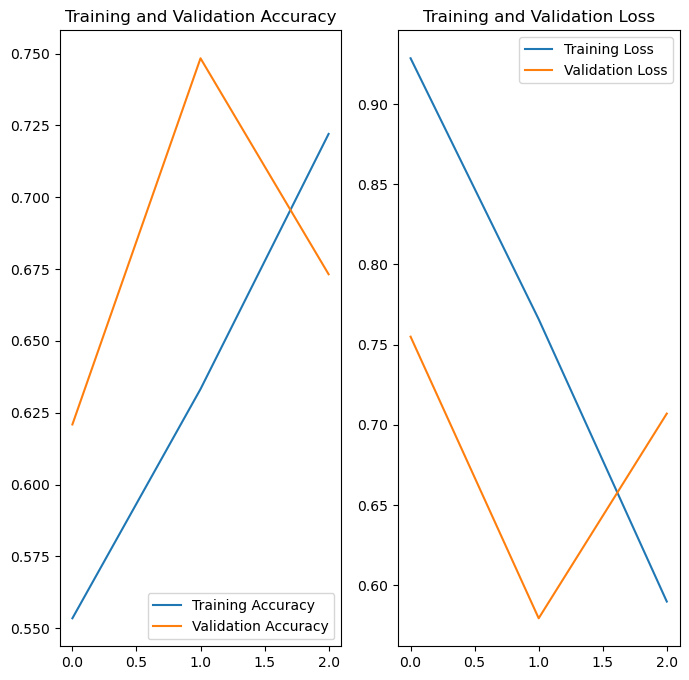

In [51]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 8s 636ms/step - loss: 0.7488 - accuracy: 0.6667


In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [54]:
import numpy as np 

1/1 [==============================] - 0s 158ms/step


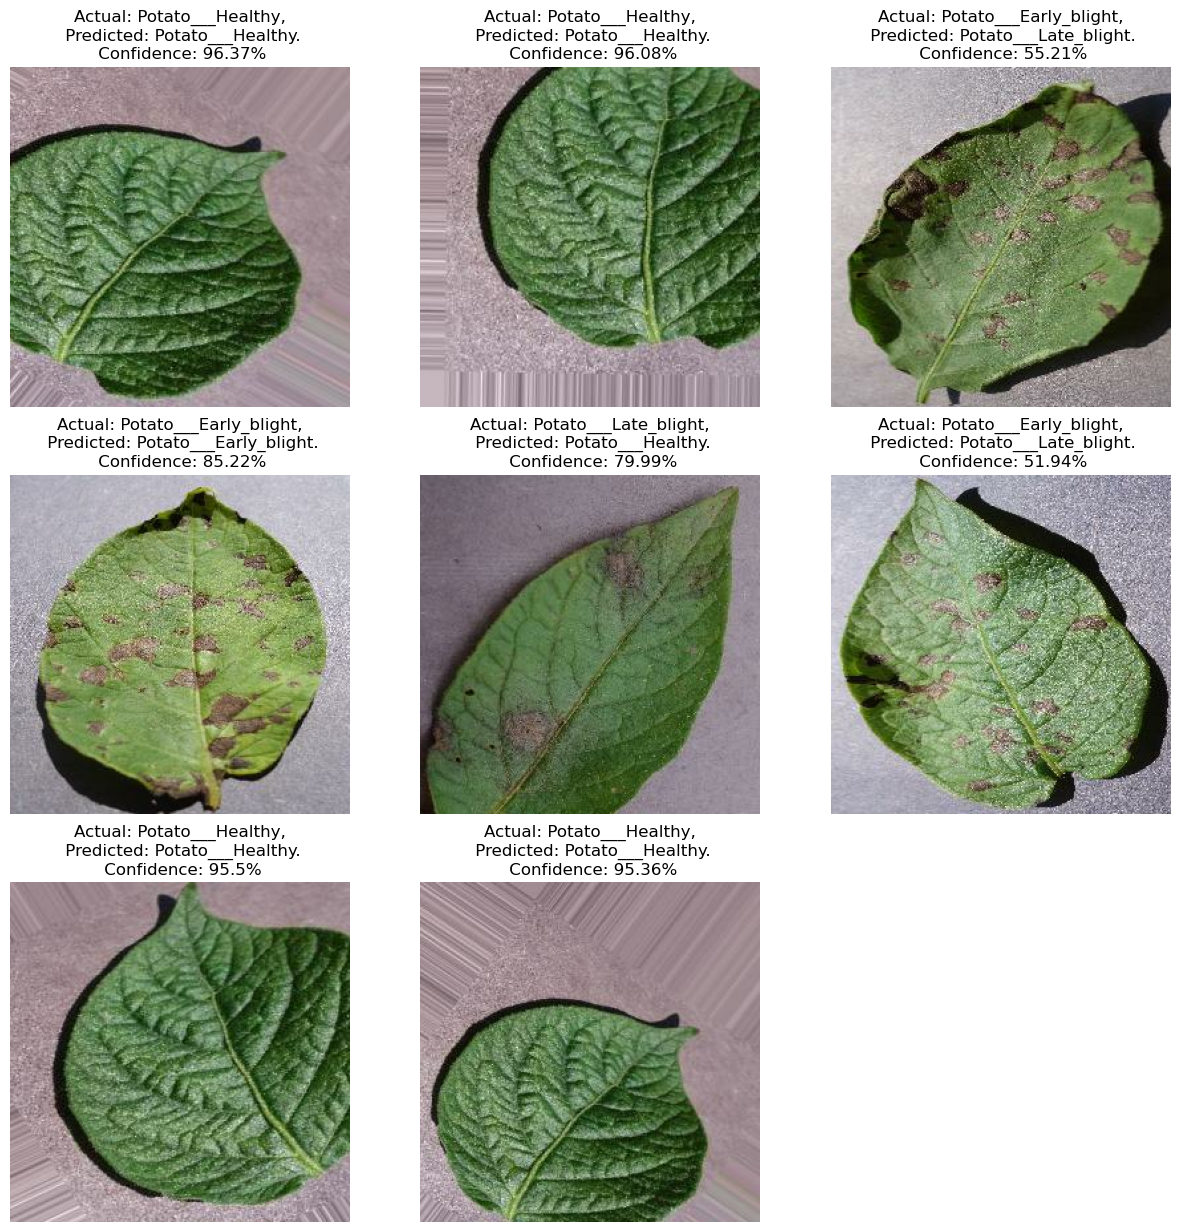

In [55]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Practice 


In [56]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class =class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class

In [57]:
y_label_pred=[]
y_label=[]

In [58]:
len(test_ds)

10

In [60]:
for j in range (10):
      for images, labels in test_ds.take(j):
            for i in range(32):
                y_label_pred.append(predict(model, images[i].numpy()))
                y_label.append(class_names[labels[i]])

1/1 [==============================] - 0s 103ms/step


In [61]:
import pandas as pd
y_pred =pd.DataFrame(y_label_pred,columns=['predicted value'])
y_actual=pd.DataFrame(y_label,columns=['Actual value'])
print(y_pred,y_actual)

            predicted value
0      Potato___Late_blight
1     Potato___Early_blight
2          Potato___Healthy
3          Potato___Healthy
4      Potato___Late_blight
...                     ...
3181       Potato___Healthy
3182  Potato___Early_blight
3183  Potato___Early_blight
3184       Potato___Healthy
3185       Potato___Healthy

[3186 rows x 1 columns]                Actual value
0     Potato___Early_blight
1     Potato___Early_blight
2      Potato___Late_blight
3          Potato___Healthy
4      Potato___Late_blight
...                     ...
3181       Potato___Healthy
3182  Potato___Early_blight
3183  Potato___Early_blight
3184       Potato___Healthy
3185       Potato___Healthy

[3186 rows x 1 columns]


In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred))

                       precision    recall  f1-score   support

Potato___Early_blight       0.82      0.70      0.75      1109
     Potato___Healthy       0.65      1.00      0.79       985
 Potato___Late_blight       0.61      0.40      0.48      1092

             accuracy                           0.69      3186
            macro avg       0.69      0.70      0.67      3186
         weighted avg       0.69      0.69      0.67      3186

